Epoch 1/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.5325 - loss: 0.7338 - val_accuracy: 0.7490 - val_loss: 0.6890 - learning_rate: 1.0000e-04
Epoch 2/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5828 - loss: 0.6685 - val_accuracy: 0.2396 - val_loss: 0.6563 - learning_rate: 1.0000e-04
Epoch 3/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 51s 780ms/step - accuracy: 0.6092 - loss: 0.6482 - val_accuracy: 0.2175 - val_loss: 0.6425 - learning_rate: 1.0000e-04
Epoch 4/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6323 - loss: 0.6258 - val_accuracy: 0.3006 - val_loss: 0.6262 - learning_rate: 1.0000e-04
Epoch 5/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6469 - loss: 0.6005 - val_accuracy: 0.3990 - val_loss: 0.5981 - learning_rate: 1.0000e-04
Epoch 6/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 53s 823ms/step - accuracy: 0.6684 - loss: 0.5723 - val_accuracy: 0.6500 - val_loss: 0.5579 - learning_rate: 1.0000e-04
Epoch 7/25
65/65 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7022 -

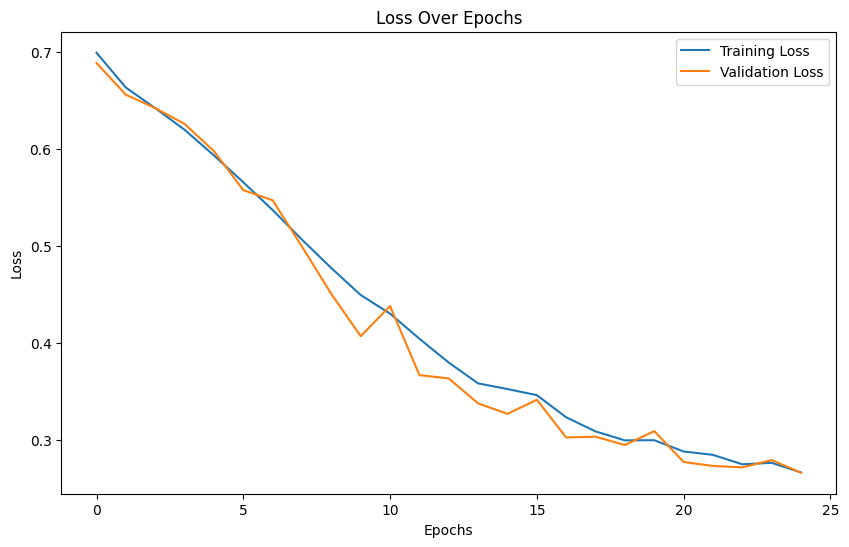

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import albumentations as A

from tensorflow.keras.layers import BatchNormalization

def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoder (Downsampling)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    # Decoder (Upsampling)
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = layers.concatenate([up5, conv3])
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = layers.concatenate([up6, conv2])
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = layers.concatenate([up7, conv1])
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    # Output layer (two channels: stamp and signature masks)
    outputs = layers.Conv2D(2, 1, activation='sigmoid')(conv7)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model



# Separate Data Generator for Training and Validation
def data_generator(overlapped_dir, stamp_dir, signature_dir, batch_size=16, shuffle=True):
    overlapped_files = os.listdir(overlapped_dir)

    if shuffle:
        np.random.shuffle(overlapped_files)

    while True:
        batch_overlapped = []
        batch_stamps = []
        batch_signatures = []


        for _ in range(batch_size):
            idx = np.random.randint(0, len(overlapped_files))
            filename = overlapped_files[idx]

            overlapped_img_path = os.path.join(overlapped_dir, filename)
            stamp_img_path = os.path.join(stamp_dir, filename)
            signature_img_path = os.path.join(signature_dir, filename)

            # Check if files exist
            if not (os.path.exists(overlapped_img_path) and
                    os.path.exists(stamp_img_path) and
                    os.path.exists(signature_img_path)):
                continue  # Skip if any file is missing

            # Load images
            overlapped_img = tf.keras.utils.load_img(overlapped_img_path,
                                                     color_mode="grayscale",
                                                     target_size=(256, 256))
            stamp_img = tf.keras.utils.load_img(stamp_img_path,
                                                color_mode="grayscale",
                                                target_size=(256, 256))
            signature_img = tf.keras.utils.load_img(signature_img_path,
                                                    color_mode="grayscale",
                                                    target_size=(256, 256))

            # Convert to arrays
            overlapped_img = tf.keras.utils.img_to_array(overlapped_img) / 255.0
            stamp_img = tf.keras.utils.img_to_array(stamp_img) / 255.0
            signature_img = tf.keras.utils.img_to_array(signature_img) / 255.0

            batch_overlapped.append(overlapped_img)
            batch_stamps.append(stamp_img)
            batch_signatures.append(signature_img)

        # Combine stamps and signatures into a single output tensor
        batch_overlapped = np.array(batch_overlapped)
        batch_stamps_signatures = np.concatenate(
            [np.array(batch_stamps), np.array(batch_signatures)], axis=-1)

        yield batch_overlapped.astype(np.float32), batch_stamps_signatures.astype(np.float32)


# Paths to datasets
overlapped_dir = "/content/drive/MyDrive/final/overlapped"
stamp_dir = "/content/drive/MyDrive/final/stamp_pre"
signature_dir = "/content/drive/MyDrive/final/signature_pre"


# Create and compile the model
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Separate train and validation generators
train_gen = data_generator(overlapped_dir=overlapped_dir,
                           stamp_dir=stamp_dir,
                           signature_dir=signature_dir,
                           batch_size=16,
                           shuffle=True)

valid_gen = data_generator(overlapped_dir=overlapped_dir,
                           stamp_dir=stamp_dir,
                           signature_dir=signature_dir,
                           batch_size=16,
                           shuffle=False)  # No shuffle for validation

# Early stopping callback to prevent overfitting
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5,
                                                      restore_best_weights=True)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=65,
    epochs=25,
    validation_data=valid_gen,
    validation_steps=20,
    callbacks=[early_stopping_cb, lr_scheduler]
)

# Save the trained model
model.save("stamp_signature_separator.h5")

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Function to predict and visualize results on a single image
def predict_and_visualize(model_path: str, image_path: str):
    # Load the trained model
    model_loaded = tf.keras.models.load_model(model_path)

    # Load and preprocess the input image
    img_original = tf.keras.utils.load_img(image_path,
                                           color_mode="grayscale",
                                           target_size=(256, 256))
    img_array = tf.keras.utils.img_to_array(img_original) / 255.0
    img_array_expanded = np.expand_dims(img_array.astype(np.float32), axis=0)

    # Predict the output masks (stamp and signature separation)
    prediction_masks = model_loaded.predict(img_array_expanded)

    # Visualize the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_array.squeeze(), cmap="gray")
    plt.title("Input (Overlapped Image)")

    plt.subplot(1, 3, 2)
    plt.imshow(prediction_masks[0][:,:,0], cmap="gray")
    plt.title("Predicted Stamp Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction_masks[0][:,:,1], cmap="gray")
    plt.title("Predicted Signature Mask")

    plt.show()


# Prediction

## Preprocessing the given data

In [1]:
import cv2
import numpy as np
import os
from pathlib import Path

def preprocess_image(image_path, output_path):
    # Read the image in color
    img = cv2.imread(image_path)

    # Convert to LAB color space for better contrast handling
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
    # to enhance contrast smoothly
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    l_enhanced = clahe.apply(l)

    # Merge back with original color channels
    lab_enhanced = cv2.merge((l_enhanced, a, b))
    enhanced = cv2.cvtColor(lab_enhanced, cv2.COLOR_LAB2BGR)

    # Gentle sharpening using a smaller kernel
    gaussian = cv2.GaussianBlur(enhanced, (3,3), 0)
    sharpened = cv2.addWeighted(enhanced, 1.2, gaussian, -0.2, 0)

    # Enhance whiteness of background using a smooth curve
    # Create a lookup table to boost near-white values
    lut = np.array([min(255, int(255 * (x/255)**0.5)) if x > 200 else x
                   for x in range(256)], dtype=np.uint8)

    # Apply LUT to each channel
    result = sharpened.copy()
    for channel in range(3):
        result[:,:,channel] = cv2.LUT(sharpened[:,:,channel], lut)

    # Optional: Very light denoising to smooth edges
    result = cv2.fastNlMeansDenoisingColored(result, None, 5, 5, 7, 21)

    # Save the preprocessed image
    cv2.imwrite(output_path, result)

def main():
    # Input and output directories
    input_dir = r"/content/drive/MyDrive/images"
    output_dir = r"/content/drive/MyDrive/prepro"

    # Create output directory if it doesn't exist
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Process all images in the input directory
    for filename in os.listdir(input_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, f"preprocessed_{filename}")

            try:
                preprocess_image(input_path, output_path)
                print(f"Processed: {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")

if __name__ == "__main__":
    main()

Processed: signature_959_1.jpg
Processed: stamp_528_1.jpg
Processed: stamp_740_1.jpg
Processed: signature_289_1.jpg
Processed: stamp_492_1.jpg
Processed: signature_246_1.jpg
Processed: stamp_490_1.jpg
Processed: stamp_314_1.jpg
Processed: stamp_975_1.jpg
Processed: signature_90_1.jpg
Processed: stamp_780_1.jpg
Processed: stamp_246_1.jpg
Processed: stamp_99_1.jpg
Processed: stamp_522_1.jpg
Processed: stamp_201_1.jpg
Processed: stamp_745_1.jpg
Processed: signature_583_1.jpg
Processed: stamp_45_1.jpg
Processed: stamp_668_1.jpg
Processed: signature_506_1.jpg
Processed: signature_26_1.jpg
Processed: signature_54_1.jpg
Processed: stamp_40_1.jpg
Processed: stamp_696_1.jpg
Processed: stamp_23_1.jpg
Processed: stamp_450_1.jpg
Processed: signature_532_1.jpg
Processed: stamp_17_1.jpg
Processed: stamp_931_1.jpg
Processed: stamp_639_1.jpg
Processed: stamp_792_1.jpg
Processed: signature_280_1.jpg
Processed: stamp_458_1.jpg
Processed: stamp_479_1.jpg
Processed: signature_18_1.jpg
Processed: signature

## Convert to grayscale

In [2]:
import os
import cv2  # OpenCV for image processing

# Define input and output directories
input_dir = "/content/drive/MyDrive/prepro"  # Replace with your input folder path
output_dir = "/content/drive/MyDrive/prepro_grayscale"  # Replace with your output folder path

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Process each image in the input directory
for filename in os.listdir(input_dir):
    input_path = os.path.join(input_dir, filename)

    # Check if it's an image file (optional, avoids errors on non-image files)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        # Read the image
        img = cv2.imread(input_path)

        if img is not None:
            # Convert to grayscale
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Save the grayscale image
            output_path = os.path.join(output_dir, filename)
            cv2.imwrite(output_path, gray_img)

print("Conversion complete! Grayscale images saved in:", output_dir)


Conversion complete! Grayscale images saved in: /content/drive/MyDrive/prepro_grayscale


## Result

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


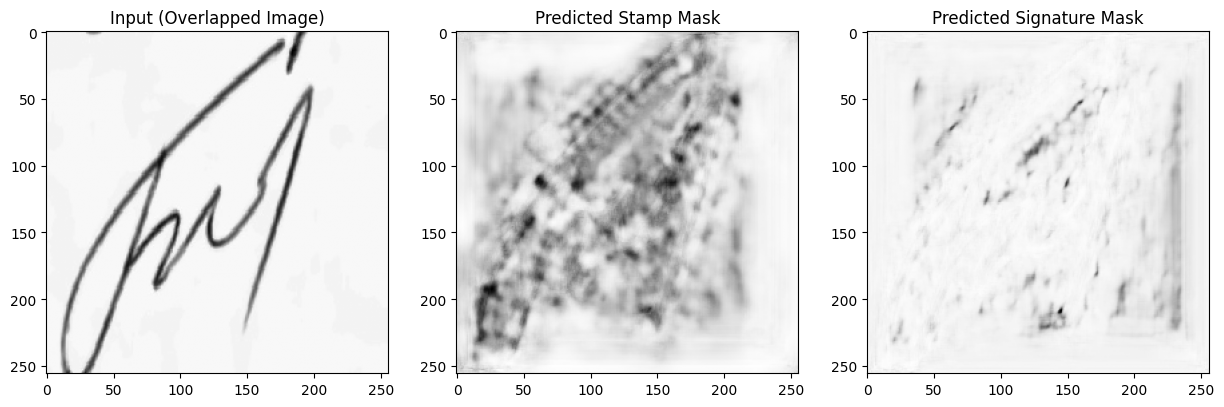

In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def predict_and_visualize(model_path: str, image_path: str):
    """
    Loads the trained U-Net model and predicts stamp and signature masks on a given image.

    Args:
        model_path (str): Path to the saved model (.h5 file).
        image_path (str): Path to the input image.

    Returns:
        None (Displays the original image and predicted masks)
    """
    # Load the trained model
    model_loaded = tf.keras.models.load_model(model_path)

    # Load and preprocess the input image
    img_original = tf.keras.utils.load_img(image_path,
                                           color_mode="grayscale",
                                           target_size=(256, 256))
    img_array = tf.keras.utils.img_to_array(img_original) / 255.0  # Normalize
    img_array_expanded = np.expand_dims(img_array.astype(np.float32), axis=0)  # Add batch dimension

    # Predict the output masks (stamp and signature separation)
    prediction_masks = model_loaded.predict(img_array_expanded)[0]  # Get first prediction

    # Visualize the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(img_array.squeeze(), cmap="gray")
    plt.title("Input (Overlapped Image)")

    plt.subplot(1, 3, 2)
    plt.imshow(prediction_masks[:, :, 0], cmap="gray")
    plt.title("Predicted Stamp Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(prediction_masks[:, :, 1], cmap="gray")
    plt.title("Predicted Signature Mask")

    plt.show()


predict_and_visualize("/content/drive/MyDrive/stamp_signature_separator.h5", "/content/drive/MyDrive/prepro_grayscale/preprocessed_signature_152_1.jpg")
